In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime


# Data Exploratory Analysis

In [2]:
with open('./datasets/business_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_businesses = pd.read_json(data_json_str)
    df_businesses['business_id'] = 'biz_' + df_businesses['business_id']
    
with open('./datasets/user_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_users = pd.read_json(data_json_str)
    
with open('./datasets/review_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews = pd.read_json(data_json_str)
    df_reviews['review_id'] = 'rev_' + df_reviews['review_id']
    df_reviews['business_id'] = 'biz_' + df_reviews['business_id']

# convert friends to list
df_users['friends'] = df_users['friends'].apply(lambda x: x.split(',') if x else [])
# convert elite to list
df_users['elite'] = df_users['elite'].apply(lambda x: x.split(',') if x else [])

C:\Users\maysa\AppData\Local\Temp\ipykernel_3980\3749381152.py:5: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_businesses = pd.read_json(data_json_str)
C:\Users\maysa\AppData\Local\Temp\ipykernel_3980\3749381152.py:12: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_users = pd.read_json(data_json_str)
C:\Users\maysa\AppData\Local\Temp\ipykernel_3980\3749381152.py:18: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews = pd.read_json(data_json_str)


In [3]:
user_ids_set = set(df_users['user_id'])

def remove_non_existing_friends(friends):
    return list(set(friends) & user_ids_set)

print("Before removing non-existing friends:", df_users['friends'].apply(len).sum())

df_users['friends'] = df_users['friends'].apply(remove_non_existing_friends)

print("After removing non-existing friends:", df_users['friends'].apply(len).sum())
print("------------------------------------")
print("Before removing users with no friends:", len(df_users))

df_users = df_users[df_users['friends'].apply(len) > 0]

print("After removing users with no friends:", len(df_users))


Before removing non-existing friends: 18945313
After removing non-existing friends: 14555
------------------------------------
Before removing users with no friends: 245354
After removing users with no friends: 14555


In [4]:
print("Before removing reviews with non-existant users: ", len(df_reviews))

# remove review if user is not in the graph
df_reviews = df_reviews[df_reviews['user_id'].isin(df_users['user_id'])]

print("After removing: ", len(df_reviews))

print("------------------------------------")

print("Before removing users with less than 2 reviews: ", len(df_users))

# remove user if they have less than 2 reviews and remove their reviews
df_users = df_users[df_users['review_count'] >= 2]


print("After removing: ", len(df_users))

print("------------------------------------")

print("Before removing reviews of non-existant businesses: ", len(df_reviews))

# remove review if business is not in the graph
df_reviews = df_reviews[df_reviews['business_id'].isin(df_businesses['business_id'])]

print("After removing: ", len(df_reviews))

print("------------------------------------")

print("Before removing reviews from non-existant users: ", len(df_reviews))

df_reviews = df_reviews[df_reviews['user_id'].isin(df_users['user_id'])]

print("After removing: ", len(df_reviews))

Before removing reviews with non-existant users:  635364
After removing:  90306
------------------------------------
Before removing users with less than 2 reviews:  14555
After removing:  13769
------------------------------------
Before removing reviews of non-existant businesses:  90306
After removing:  90305
------------------------------------
Before removing reviews from non-existant users:  90305
After removing:  89515


In [5]:
print("Before removing businesses with no reviews: ", len(df_businesses))

# remove business if they have less than 2 reviews
df_businesses = df_businesses[df_businesses['review_count'] >= 2]

print("After removing: ", len(df_businesses))

print("------------------------------------")

print("Before bussinesses that are not opened: ", len(df_businesses))

# remove businesses that are not opened
df_businesses = df_businesses[df_businesses['is_open'] == 1]

print("After removing: ", len(df_businesses))

Before removing businesses with no reviews:  6209
After removing:  6209
------------------------------------
Before bussinesses that are not opened:  6209
After removing:  4649


In [6]:
print("Before removing reviews of non-existant businesses: ", len(df_reviews))

# remove reviews if they are not in the business dataset
df_reviews = df_reviews[df_reviews['business_id'].isin(df_businesses['business_id'])]

print("After removing: ", len(df_reviews))

# reset indexes
df_businesses.reset_index(drop=True, inplace=True)
df_users.reset_index(drop=True, inplace=True)
df_reviews.reset_index(drop=True, inplace=True)

Before removing reviews of non-existant businesses:  89515
After removing:  71944


In [7]:
import plotly.graph_objects as go

lats = df_businesses['latitude']
lons = df_businesses['longitude']
names = df_businesses['name']
stars = df_businesses['stars']

colors = []
for star in stars:
    if star >= 4.0:
        colors.append('green')
    elif star >= 3.0:
        colors.append('yellow')
    else:
        colors.append('red')
        

fig = go.Figure(go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=4,
            color=colors,
            opacity=0.7
        ),
        text=names,
    ))
legend_entries = [
    {'label': 'Rating >= 4.5', 'color': 'green'},
    {'label': '4.0 <= Rating < 4.5', 'color': 'yellow'},
    {'label': 'Rating < 4.0', 'color': 'red'}
]

for entry in legend_entries:
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=10),
        showlegend=True,
        name=entry['label'],
        line=dict(color=entry['color'])
    ))

fig.update_layout(
    title= "Business Locations in New Orleans",
    autosize = True,
    hovermode='closest',
    mapbox =dict(
        accesstoken="pk.eyJ1IjoidG9tYXNnNyIsImEiOiJjbHVuNWtsOWEwZnNlMmpwbmtqM2gwa213In0.8cGFuz6zBfMNItCu791cYQ",
        bearing=0,
        center=dict(
            lat=30.0,
            lon=-90.0
        ),
        pitch=0,
        zoom=10
    ),
)

for trace in fig.data:
    if trace.name in [legend_entry['label'] for legend_entry in legend_entries]:
        trace.marker.size = 20

fig.show()

    

In [8]:
# top 5 categories
df_businesses['categories'] = df_businesses['categories'].fillna('')
categories = df_businesses['categories'].apply(lambda x: x.split(','))
categories = categories.explode()
categories = categories.value_counts()
categories = categories[:5]

fig = go.Figure(go.Bar(
    x=categories.index,
    y=categories.values
))

fig.update_layout(
    title="Top 5 Categories",
    xaxis_title="Category",
    yaxis_title="Count"
)

fig.show()

In [9]:
# all attributes that exist in df_business categories variable
attributes = df_businesses['attributes'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else [])
attributes = attributes.explode()
attributes = attributes.value_counts()

# only top 5
attributes = attributes[:5]

fig = go.Figure(go.Bar(
    x=attributes.index,
    y=attributes.values
))

fig.update_layout(
    title="Attributes",
    xaxis_title="Attribute",
    yaxis_title="Count"
)

fig.show()

In [10]:
ratings = df_reviews['stars'].value_counts()

# Calcular a porcentagem de cada classificação
total_ratings = ratings.sum()
percentage_ratings = (ratings / total_ratings) * 100

# Criar texto para exibir a porcentagem em cada barra
text = [f'{count} ({percentage:.2f}%)' for count, percentage in zip(ratings.values, percentage_ratings.values)]

fig = go.Figure(go.Bar(
    x=ratings.index,
    y=ratings.values,
    text=text,  
    textposition='auto',
))

fig.update_layout(
    title="Distribution of User Ratings",
    xaxis_title="Rating",
    yaxis_title="Count"
)

fig.show()


# Social Network Analysis

13769
Number of nodes:  13769


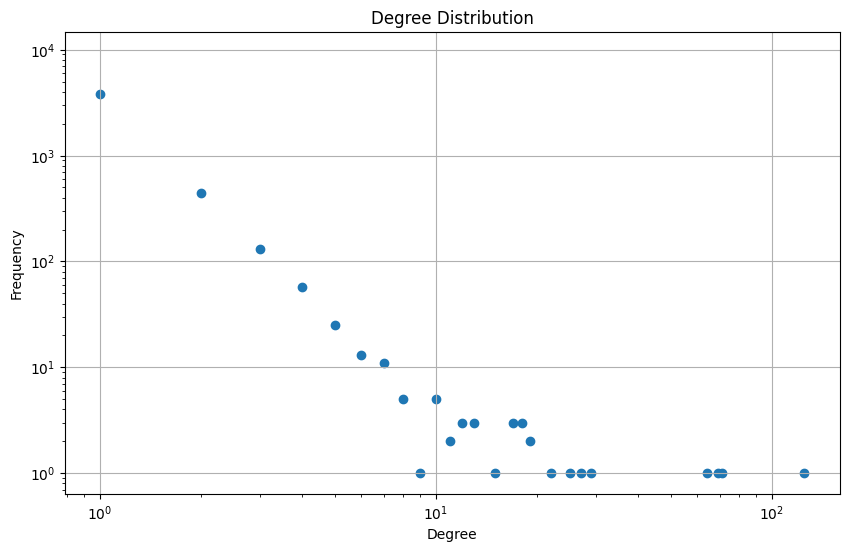

Nodes and edges: 13769 3179


In [11]:
network = nx.Graph()

print(len(df_users['user_id']))

network.add_nodes_from(df_users['user_id'])



for user,friends in zip(df_users['user_id'], df_users['friends']):
    for friend in friends:
        if friend in df_users['user_id'].values:
            network.add_edge(user, friend)

print("Number of nodes: ", network.number_of_nodes())
# sorted list with degree of each node
degree_sequence = sorted([d for n, d in network.degree()], reverse=True)

degree_freq = {}
for degree in degree_sequence:
    if degree in degree_freq:
        degree_freq[degree] += 1
    else:
        degree_freq[degree] = 1


# create degree distribution plot, not histogram
plt.figure(figsize=(10, 6))
plt.scatter(degree_freq.keys(), degree_freq.values())
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.grid(True)
plt.title('Degree Distribution')
plt.show()

print("Nodes and edges:", network.number_of_nodes(), network.number_of_edges())

In [12]:
# len of list where degree is better than 10
topX = len([d for n, d in network.degree() if d > 10])
print(topX)

25


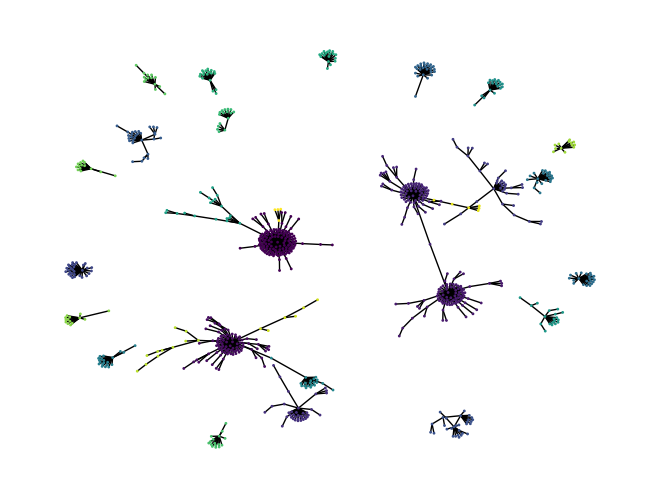

In [13]:
# Subgraph induced by node with higher degree
max_degree_node = sorted(dict(network.degree()).items(), key=lambda x: x[1], reverse=True)[:topX]
max_degree_node_ids = [node[0] for node in max_degree_node]
subgraph_nodes = set()

for node in max_degree_node_ids:
    subgraph_nodes |= set(nx.node_connected_component(network, node))

g_sub = network.subgraph(subgraph_nodes)

# Communities 
communities = nx.community.greedy_modularity_communities(g_sub)

node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in g_sub.nodes()]

pos = nx.spring_layout(g_sub)
nx.draw(g_sub, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()

In [14]:
# find communities in main graph
communities = nx.community.greedy_modularity_communities(network)

node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in network.nodes()]

pos = nx.kamada_kawai_layout(network)
nx.draw(network, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()


KeyboardInterrupt



In [ ]:
# density and assortativity
density = nx.density(network)

print("Density: ", density)

assortativity = nx.degree_assortativity_coefficient(network)

print("Assortativity: ", assortativity)

Density:  3.353878043077256e-05
Assortativity:  -0.08572980386269059


In [ ]:
communities = nx.community.greedy_modularity_communities(network)

# add attribute of review count to each node in network
review_count = df_users.set_index('user_id')['review_count'].to_dict()

nx.set_node_attributes(network, review_count, 'review_count')

# add attribute of elite to each node in network
elite = {}
for index,row in df_users.iterrows():
    is_elite = len(row['elite']) > 0
    if is_elite:
        elite[row['user_id']] = 1
    else:
        elite[row['user_id']] = 0

nx.set_node_attributes(network, elite, 'elite')

pd_data = []

# print density and assortativity, len of nodes of each community top 5
for i, community in enumerate(communities):
    subgraph = network.subgraph(community)
    density = nx.density(subgraph)
    assortativity_review_count = nx.attribute_assortativity_coefficient(subgraph,'review_count')
    assortativity_elite = nx.attribute_assortativity_coefficient(subgraph,'elite')
    
    #print(f"Community {i}: Density: {density}, Assortativity-Review-Count: {assortativity_review_count}, Assortativity-Elite: {assortativity_elite}, Number of Nodes: {len(community)}")
    
    pd_data.append({
        'Community': i,
        'Density': round(density,4),
        'Assortativity-Review-Count': round(assortativity_review_count,4),
        'Assortativity-Elite': round(assortativity_elite,4),
        'Number of Nodes': len(community)
    })
    
    if i == 4:
        break
    
# print for whole graph density, assortativity and number of nodes
density = nx.density(network)
assortativity_review_count = nx.attribute_assortativity_coefficient(network,'review_count')
assortativity_elite = nx.attribute_assortativity_coefficient(network,'elite')

print(f"Whole Graph: Density: {density}, Assortativity-Review-Count: {assortativity_review_count}, Assortativity-Elite: {assortativity_elite}, Number of Nodes: {network.number_of_nodes()}")

df_pd_data = pd.DataFrame(pd_data)
df_pd_data

Community 0: Density: 0.014184397163120567, Assortativity-Review-Count: -0.2457987900515348, Assortativity-Elite: -0.6756176154672395, Number of Nodes: 141
Community 1: Density: 0.018018018018018018, Assortativity-Review-Count: -0.12778450927393048, Assortativity-Elite: -0.310824230387289, Number of Nodes: 111
Community 2: Density: 0.022222222222222223, Assortativity-Review-Count: -0.18524614693999705, Assortativity-Elite: -0.487841945288754, Number of Nodes: 90
Community 3: Density: 0.022727272727272728, Assortativity-Review-Count: -0.18639498929675738, Assortativity-Elite: -0.5190476190476191, Number of Nodes: 88
Community 4: Density: 0.05405405405405406, Assortativity-Review-Count: -0.1846435100548446, Assortativity-Elite: -0.21251002405773867, Number of Nodes: 37
Whole Graph: Density: 3.353878043077256e-05, Assortativity-Review-Count: 0.006478363126604921, Assortativity-Elite: 0.054291842753725075, Number of Nodes: 13769


,Community,Density,Assortativity-Review-Count,Assortativity-Elite,Number of Nodes
0,0,0.0142,-0.2458,-0.6756,141
1,1,0.0180,-0.1278,-0.3108,111
2,2,0.0222,-0.1852,-0.4878,90
3,3,0.0227,-0.1864,-0.5190,88
4,4,0.0541,-0.1846,-0.2125,37


In [ ]:
# print number of nodes, edges 
print("Nodes and edges:", network.number_of_nodes(), network.number_of_edges())

Nodes and edges: 13769 3179


In [ ]:
elite_users = []
for node in network.nodes():
    if df_users[df_users['user_id'] == node]['elite'].values[0]:
        elite_users.append(node)

print("Elite users: ", len(elite_users))

Elite users:  3125


In [ ]:
# pie chart elite users vs non-elite users
elite_users_len = len(elite_users)
non_elite_users_len = len(network.nodes()) - elite_users_len
print("Elite users: ", elite_users_len)
print("Non-elite users: ", non_elite_users_len)

fig = go.Figure(go.Pie(
    labels=['Elite Users', 'Non-Elite Users'],
    values=[elite_users_len, non_elite_users_len]
))

fig.update_layout(
    title="Elite Users vs Non-Elite Users"
)

fig.show()

Elite users:  3125
Non-elite users:  10644


In [ ]:
# remove isolates
network.remove_nodes_from(list(nx.isolates(network)))

print("Number of isolates: ", len(list(nx.isolates(network))))

Number of isolates:  0


In [ ]:
betwenness = nx.betweenness_centrality(network)

sorted_betweenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)

top_percent = 10
top_nodes = sorted_betweenness[:int(len(sorted_betweenness) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by betweenness centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by betweenness centrality: 49.333333333333336%


In [ ]:
degree = nx.degree_centrality(network)

sorted_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_degree[:int(len(sorted_degree) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by degree centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by degree centrality: 54.888888888888886%


In [ ]:
# eigen vector centrality
eigen = nx.eigenvector_centrality(network)

sorted_eigen = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_eigen[:int(len(sorted_eigen) * top_percent / 100)]

elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by eigen vector centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by eigen vector centrality: 14.000000000000002%


In [ ]:
# closeness centrality
closeness = nx.closeness_centrality(network)

sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_closeness[:int(len(sorted_closeness) * top_percent / 100)]

elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by closeness centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by closeness centrality: 13.555555555555557%


In [ ]:
percentages = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

user_percentages = []

elite_percentages_in_top_betweenness = []
elite_percentages_in_top_closeness = []
elite_percentages_in_top_degree = []
elite_percentages_in_top_eigen = []

for elite_percentages in percentages:
    top_nodes = sorted_betweenness[:int(len(sorted_betweenness) * elite_percentages / 100)]
    elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
    elite_percentages_in_top_betweenness.append(elite_users_in_top / len(top_nodes) * 100)
    
    top_nodes = sorted_closeness[:int(len(sorted_closeness) * elite_percentages / 100)]
    elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
    elite_percentages_in_top_closeness.append(elite_users_in_top / len(top_nodes) * 100)
    
    top_nodes = sorted_degree[:int(len(sorted_degree) * elite_percentages / 100)]
    elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
    elite_percentages_in_top_degree.append(elite_users_in_top / len(top_nodes) * 100)
    
    top_nodes = sorted_eigen[:int(len(sorted_eigen) * elite_percentages / 100)]
    elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
    elite_percentages_in_top_eigen.append(elite_users_in_top / len(top_nodes) * 100)
    
    user_percentages.append(elite_percentages)

fig = go.Figure()

fig.add_trace(go.Scatter(x=user_percentages, y=elite_percentages_in_top_betweenness, mode='lines+markers', name='Betweenness Centrality'))

fig.add_trace(go.Scatter(x=user_percentages, y=elite_percentages_in_top_closeness, mode='lines+markers', name='Closeness Centrality'))

fig.add_trace(go.Scatter(x=user_percentages, y=elite_percentages_in_top_degree, mode='lines+markers', name='Degree Centrality'))

fig.add_trace(go.Scatter(x=user_percentages, y=elite_percentages_in_top_eigen, mode='lines+markers', name='Eigen Vector Centrality'))



fig.update_layout(
    title="Elite Percentage in Top X% by Betweenness Centrality",
    xaxis_title="Top Percentage",
    yaxis_title="Elite Percentage",
    xaxis= dict(tickvals=percentages, ticktext=[f"{percentage}%" for percentage in percentages])
)

fig.show()

In [ ]:
# total num of reviews for elite and non-elite users
elite_users_reviews = df_reviews[df_reviews['user_id'].isin(elite_users)]
non_elite_users_reviews = df_reviews[~df_reviews['user_id'].isin(elite_users)]

elite_users_reviews_count = len(elite_users_reviews)
non_elite_users_reviews_count = len(non_elite_users_reviews)

print(f"Total number of reviews by elite users: {elite_users_reviews_count}")
print(f"Total number of reviews by non-elite users: {non_elite_users_reviews_count}")

Total number of reviews by elite users: 39257
Total number of reviews by non-elite users: 32687


In [ ]:
user_grouped_reviews = df_reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()

user_reviews = {}

for user,group in user_grouped_reviews.groupby('user_id'):
    user_reviews[user] = group.set_index('business_id')['stars'].to_dict()
    
# print user reviews index 0 
print(user_reviews[list(user_reviews.keys())[0]])

{'biz_GBTPC53ZrG1ZBY3DT8Mbcw': 4.0, 'biz_LY6hHivaMJIPJNv_3oBIPQ': 1.0, 'biz_hLlDzRaDGN-0SlEWk0xTpQ': 5.0, 'biz_mnq8JNUjIBwUoLBk-b2V9g': 4.0}


In [ ]:
network_copy = network.copy()

def calc_similarity(common_businesses,reviews1, reviews2):

    stars1 = np.array([reviews1[b] for b in common_businesses])
    stars2 = np.array([reviews2[b] for b in common_businesses])
    
    rating_diff = np.abs(stars1 - stars2)
    sim_metric = np.mean(rating_diff)
    
    return sim_metric

edges = []
for user1, user2 in combinations(network.nodes(), 2):
    reviews1 = user_reviews.get(user1, {})
    reviews2 = user_reviews.get(user2, {})
    
    common_businesses = set(reviews1.keys()) & set(reviews2.keys())
    
    common_reviews_count = len(common_businesses)
    
    if common_reviews_count >= 5:
        similarity = calc_similarity(common_businesses, reviews1, reviews2)
        
        if similarity < 0.5:
            edges.append((user1, user2, similarity))

print(edges[0:5])


[('SZDeASXq7o05mMNLshsdIA', 'iZpzJ9k4dDgBjuC27MbjvQ', 0.4), ('SZDeASXq7o05mMNLshsdIA', 'GJv1yf_IhUZqpDjFr86DmA', 0.4), ('v9VCObZVWhOPdm1rKt8Dvg', 'Hjfbo7zwpCI5CI5OjkGMqw', 0.4166666666666667), ('v9VCObZVWhOPdm1rKt8Dvg', 'GJv1yf_IhUZqpDjFr86DmA', 0.45454545454545453), ('v9VCObZVWhOPdm1rKt8Dvg', 'M7Yki2cfEgXNuCg_6Bw1Cg', 0.35714285714285715)]


In [ ]:
for edge in edges:
    network_copy.add_edge(edge[0], edge[1])
    

print("Nodes and edges:", network_copy.number_of_nodes(), network_copy.number_of_edges())

Nodes and edges: 4500 4897


In [ ]:
betwenness = nx.betweenness_centrality(network_copy)

sorted_betweenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)

top_percent = 10
top_nodes = sorted_betweenness[:int(len(sorted_betweenness) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by betweenness centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by betweenness centrality: 65.77777777777779%


In [ ]:
degree = nx.degree_centrality(network_copy)

sorted_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_degree[:int(len(sorted_degree) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by degree centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by degree centrality: 69.11111111111111%


In [ ]:
# eigen vector centrality
eigen = nx.eigenvector_centrality(network_copy)

sorted_eigen = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_eigen[:int(len(sorted_eigen) * top_percent / 100)]

elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by eigen vector centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by eigen vector centrality: 57.333333333333336%


In [ ]:
# closeness centrality
closeness = nx.closeness_centrality(network_copy)

sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_closeness[:int(len(sorted_closeness) * top_percent / 100)]

elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by closeness centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by closeness centrality: 57.55555555555556%


In [ ]:
percentages = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

user_percentages = []

elite_percentages_in_top_betweenness = []
elite_percentages_in_top_closeness = []
elite_percentages_in_top_degree = []
elite_percentages_in_top_eigen = []

for elite_percentages in percentages:
    top_nodes = sorted_betweenness[:int(len(sorted_betweenness) * elite_percentages / 100)]
    elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
    elite_percentages_in_top_betweenness.append(elite_users_in_top / len(top_nodes) * 100)
    
    top_nodes = sorted_closeness[:int(len(sorted_closeness) * elite_percentages / 100)]
    elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
    elite_percentages_in_top_closeness.append(elite_users_in_top / len(top_nodes) * 100)
    
    top_nodes = sorted_degree[:int(len(sorted_degree) * elite_percentages / 100)]
    elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
    elite_percentages_in_top_degree.append(elite_users_in_top / len(top_nodes) * 100)
    
    top_nodes = sorted_eigen[:int(len(sorted_eigen) * elite_percentages / 100)]
    elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
    elite_percentages_in_top_eigen.append(elite_users_in_top / len(top_nodes) * 100)
    
    user_percentages.append(elite_percentages)

fig = go.Figure()

fig.add_trace(go.Scatter(x=user_percentages, y=elite_percentages_in_top_betweenness, mode='lines+markers', name='Betweenness Centrality'))

fig.add_trace(go.Scatter(x=user_percentages, y=elite_percentages_in_top_closeness, mode='lines+markers', name='Closeness Centrality'))

fig.add_trace(go.Scatter(x=user_percentages, y=elite_percentages_in_top_degree, mode='lines+markers', name='Degree Centrality'))

fig.add_trace(go.Scatter(x=user_percentages, y=elite_percentages_in_top_eigen, mode='lines+markers', name='Eigen Vector Centrality'))



fig.update_layout(
    title="Elite Percentage in Top X% by Betweenness Centrality",
    xaxis_title="Top Percentage",
    yaxis_title="Elite Percentage",
    xaxis= dict(tickvals=percentages, ticktext=[f"{percentage}%" for percentage in percentages])
)

fig.show()

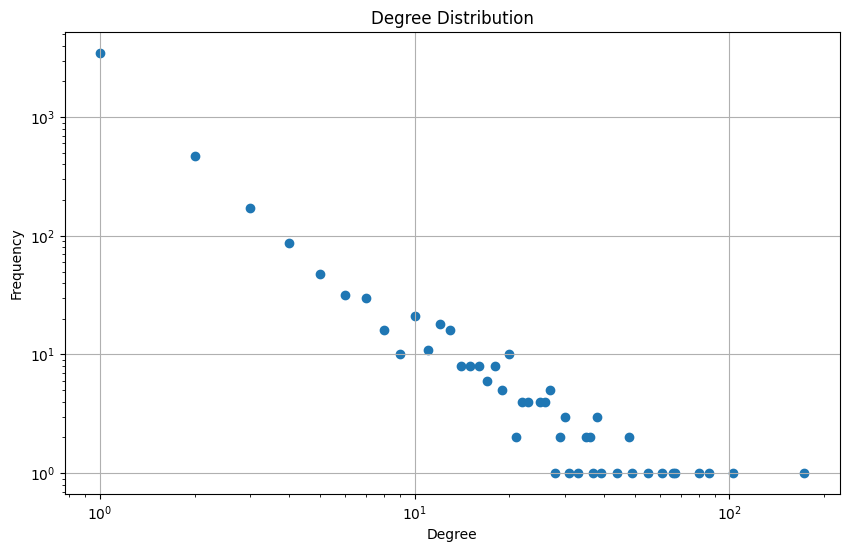

In [ ]:
degree_sequence = sorted([d for n, d in network_copy.degree()], reverse=True)

degree_freq = {}
for degree in degree_sequence:
    if degree in degree_freq:
        degree_freq[degree] += 1
    else:
        degree_freq[degree] = 1


# create degree distribution plot, not histogram
plt.figure(figsize=(10, 6))
plt.scatter(degree_freq.keys(), degree_freq.values())
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.grid(True)
plt.title('Degree Distribution')
plt.show()


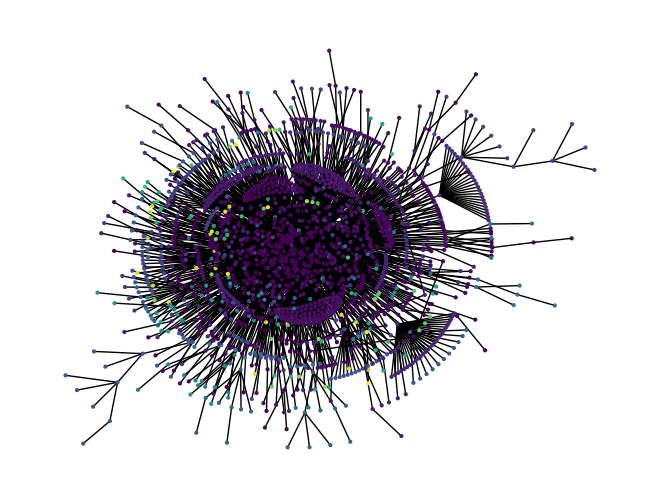

In [ ]:
# Subgraph induced by node with higher degree
max_degree_node = sorted(dict(network_copy.degree()).items(), key=lambda x: x[1], reverse=True)[:10]
max_degree_node_ids = [node[0] for node in max_degree_node]
subgraph_nodes = set()

for node in max_degree_node_ids:
    subgraph_nodes |= set(nx.node_connected_component(network_copy, node))

g_sub = network_copy.subgraph(subgraph_nodes)


sub_communities = nx.community.greedy_modularity_communities(g_sub)

node_to_community = {}
for i, community in enumerate(sub_communities):
    for node in community:
        node_to_community[node] = i


colors = [node_to_community[node] for node in g_sub.nodes()]

pos = nx.kamada_kawai_layout(g_sub)
nx.draw(g_sub, pos, node_color=colors, node_size=4, with_labels=False)
plt.show()

In [ ]:
# print degrees sorted
print(sorted(dict(network_copy.degree()).items(), key=lambda x: x[1], reverse=True)[:10])

[('5tXRxr4T24Awl7vjyCvIcQ', 173), ('Xw7ZjaGfr0WNVt6s_5KZfA', 103), ('GJv1yf_IhUZqpDjFr86DmA', 86), ('h8_Mzh_ndxFwxQgLZsRs9w', 80), ('0Igx-a1wAstiBDerGxXk2A', 67), ('qpFCY_wj8_G-HOV8MxIaHw', 66), ('SbpGncVoxFIi_J2xOelJYQ', 61), ('oHjUPJHEOGJsrPqu3B_MnA', 55), ('iZpzJ9k4dDgBjuC27MbjvQ', 49), ('8JaJl5ZRMT4o2q10DVIZGg', 48)]


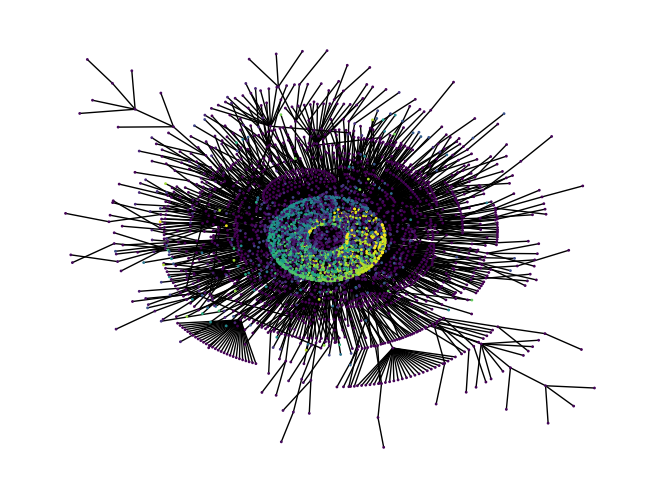

In [ ]:
# Communities 
communities_2 = nx.community.greedy_modularity_communities(network_copy)

node_to_community_2 = {}
for i, community in enumerate(communities_2):
    for node in community:
        node_to_community_2[node] = i

# Color nodes by community
colors = [node_to_community_2[node] for node in network_copy.nodes()]

pos = nx.spring_layout(network_copy)
nx.draw(network_copy, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()

    

In [ ]:
communities_2 = nx.community.greedy_modularity_communities(network_copy)

# add attribute of review count to each node in network
review_count = df_users.set_index('user_id')['review_count'].to_dict()

nx.set_node_attributes(network_copy, review_count, 'review_count')

# add attribute of elite to each node in network
elite = {}
for index,row in df_users.iterrows():
    is_elite = len(row['elite']) > 0
    if is_elite:
        elite[row['user_id']] = 1
    else:
        elite[row['user_id']] = 0

nx.set_node_attributes(network_copy, elite, 'elite')

pd_data = []

# print density and assortativity, len of nodes of each community top 5
for i, community in enumerate(communities_2):
    subgraph = network.subgraph(community)
    density = nx.density(subgraph)
    assortativity_review_count = nx.attribute_assortativity_coefficient(subgraph,'review_count')
    assortativity_elite = nx.attribute_assortativity_coefficient(subgraph,'elite')
    
    
    #print(f"Community {i}: Density: {density}, Assortativity-Review-Count: {assortativity_review_count}, Assortativity-Elite: {assortativity_elite}, Number of Nodes: {len(community)}")
    
    pd_data.append({
        'Community': i,
        'Density': round(density,4),
        'Assortativity-Review-Count': round(assortativity_review_count,4),
        'Assortativity-Elite': round(assortativity_elite,4),
        'Number of Nodes': len(community)
    })
    if i == 4:
        break

# print for whole graph density, assortativity and number of nodes
density = nx.density(network_copy)
assortativity_review_count = nx.attribute_assortativity_coefficient(network_copy,'review_count')
assortativity_elite = nx.attribute_assortativity_coefficient(network_copy,'elite')

print(f"Whole Graph: Density: {density}, Assortativity-Review-Count: {assortativity_review_count}, Assortativity-Elite: {assortativity_elite}, Number of Nodes: {network_copy.number_of_nodes()}")

df_pd_data = pd.DataFrame(pd_data)
df_pd_data

Community 0: Density: 0.0025737085769980505, Assortativity-Review-Count: -0.008928413257985086, Assortativity-Elite: -0.27736131934033, Number of Nodes: 513
Community 1: Density: 0.00642570281124498, Assortativity-Review-Count: -0.04029856568835257, Assortativity-Elite: -0.16666666666666696, Number of Nodes: 250
Community 2: Density: 0.008776103621464446, Assortativity-Review-Count: -0.10830113096081083, Assortativity-Elite: -0.6144578313253012, Number of Nodes: 195
Community 3: Density: 0.009342653582470762, Assortativity-Review-Count: -0.05314593170088943, Assortativity-Elite: -0.3384065848734276, Number of Nodes: 173
Community 4: Density: 0.021473158551810236, Assortativity-Review-Count: -0.15274314214463838, Assortativity-Elite: -0.627906976744186, Number of Nodes: 90
Whole Graph: Density: 0.0004837618236151243, Assortativity-Review-Count: 0.005263595953216424, Assortativity-Elite: 0.21911959711368093, Number of Nodes: 4500


,Community,Density,Assortativity-Review-Count,Assortativity-Elite,Number of Nodes
0,0,0.0026,-0.0089,-0.2774,513
1,1,0.0064,-0.0403,-0.1667,250
2,2,0.0088,-0.1083,-0.6145,195
3,3,0.0093,-0.0531,-0.3384,173
4,4,0.0215,-0.1527,-0.6279,90


# Recomender systems

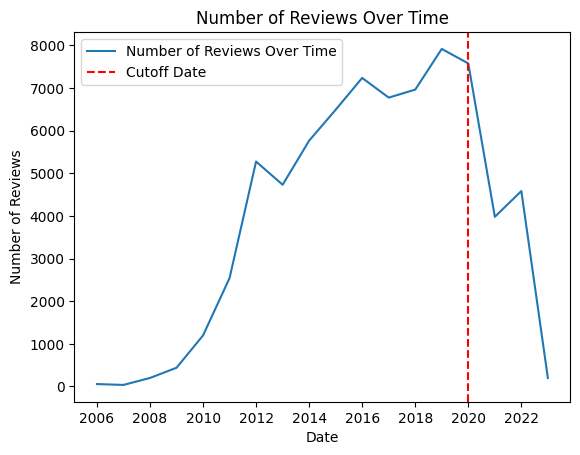

In [ ]:
from surprise import SVD, Dataset, Reader,NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_reviews[['user_id', 'business_id', 'stars']], reader)

# build trainset in a way that 80% are reviews from the past and 20% are the most recent reviews
df_reviews_sorted = df_reviews.sort_values(by='date')

total_reviews = len(df_reviews_sorted)

cutoff_index = int(total_reviews * 0.8)

cutoff_data = df_reviews_sorted.iloc[cutoff_index]['date']

train_data = df_reviews_sorted[df_reviews_sorted['date'] < cutoff_data]
test_data = df_reviews_sorted[df_reviews_sorted['date'] >= cutoff_data]

reviews_over_year = df_reviews_sorted.resample('YE', on='date').size()
cutoff_index = int(len(reviews_over_year) * 0.8)

cutoff_date = reviews_over_year.index[cutoff_index]

plt.figure
plt.plot(reviews_over_year.index, reviews_over_year.values, label='Number of Reviews Over Time')
plt.axvline(cutoff_date, color='red', linestyle='--', label='Cutoff Date')
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

In [ ]:
trainset = Dataset.load_from_df(train_data[['user_id', 'business_id', 'stars']], reader).build_full_trainset() # past reviews
testset = list(test_data[['user_id', 'business_id', 'stars']].itertuples(index=False, name=None)) # most recent reviews

In [ ]:
from surprise import SVD, Dataset, Reader,NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from time import time

def evaluate_algorithm(algo, trainset, testset):
    start_train_time = time()
    algo.fit(trainset)
    end_train_time = time()
    train_time = end_train_time - start_train_time
    
    start_test_time = time()
    predictions = algo.test(testset)
    end_test_time = time()
    test_time = end_test_time - start_test_time
    
    rmse = accuracy.rmse(predictions)
    
    return rmse, train_time, test_time

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(user_grouped_reviews[['user_id', 'business_id', 'stars']], reader)

benchmark = []
for algorithm in [SVD(), KNNBasic(), KNNWithZScore(), KNNWithMeans(), KNNWithZScore(), NormalPredictor()]:
    # use train and test data
    results = evaluate_algorithm(algorithm, trainset, testset)
    
    tmp = pd.DataFrame.from_dict({'RMSE': [results[0]], 'Train Time': [results[1]], 'Test Time': [results[2]]})
    tmp['Algorithm'] = str(algorithm).split('.')[-1].split(' ')[0]
    benchmark.append(tmp)

df_benchmark = pd.concat(benchmark)
df_benchmark.set_index('Algorithm').sort_values('RMSE')
df_benchmark

RMSE: 1.1383
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2130
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2335
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2275
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2335
RMSE: 1.5813


,RMSE,Train Time,Test Time,Algorithm
0,1.138332,0.705205,0.105327,SVD
0,1.213047,2.207968,0.678298,KNNBasic
0,1.233476,2.772785,1.174417,KNNWithZScore
0,1.227495,2.794855,0.598675,KNNWithMeans
0,1.233476,4.417647,1.106080,KNNWithZScore
0,1.581272,0.075222,0.175605,NormalPredictor


In [ ]:
benchmark = []

for algorithm in [SVD(), KNNBasic(sim_options={'user_based': True}), KNNWithZScore(sim_options={'user_based': True}), KNNWithMeans(sim_options={'user_based': True}), NormalPredictor()]:

    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    

    mean_rmse = results['test_rmse'].mean()
    mean_fit_time = np.mean(results['fit_time'])
    mean_test_time = np.mean(results['test_time'])
    

    tmp = pd.DataFrame.from_dict({'Mean RMSE': [mean_rmse], 'Mean Fit Time': [mean_fit_time], 'Mean Test Time': [mean_test_time]})
    tmp['Algorithm'] = str(algorithm).split('.')[-1].split(' ')[0]
    benchmark.append(tmp)


df_benchmark = pd.concat(benchmark)
df_benchmark = df_benchmark.sort_values(by='Mean RMSE')
df_benchmark

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,Mean RMSE,Mean Fit Time,Mean Test Time,Algorithm
0,1.080251,1.085739,0.224451,SVD
0,1.173001,2.698584,1.242545,KNNBasic
0,1.193245,2.813525,1.221514,KNNWithMeans
0,1.210332,3.579068,1.219033,KNNWithZScore
0,1.522413,0.076152,0.084202,NormalPredictor


In [ ]:
benchmark_item_based = []

for algorithm in [KNNBasic(sim_options={'user_based': False}), KNNWithZScore(sim_options={'user_based': False}), KNNWithMeans(sim_options={'user_based': False}), NormalPredictor()]:

    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    

    mean_rmse = results['test_rmse'].mean()
    mean_fit_time = np.mean(results['fit_time'])
    mean_test_time = np.mean(results['test_time'])
    

    tmp = pd.DataFrame.from_dict({'Mean RMSE': [mean_rmse], 'Mean Fit Time': [mean_fit_time], 'Mean Test Time': [mean_test_time]})
    tmp['Algorithm'] = str(algorithm).split('.')[-1].split(' ')[0]
    benchmark_item_based.append(tmp)


df_benchmark_item_based = pd.concat(benchmark_item_based)
df_benchmark_item_based = df_benchmark_item_based.sort_values(by='Mean RMSE')

df_benchmark_item_based

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,Mean RMSE,Mean Fit Time,Mean Test Time,Algorithm
0,1.168859,0.459838,0.852821,KNNWithMeans
0,1.172168,0.664006,0.857876,KNNWithZScore
0,1.218812,0.418191,0.763478,KNNBasic
0,1.527799,0.068902,0.094973,NormalPredictor


In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_epochs': [5, 10, 15],          
    'lr_all': [0.002, 0.005, 0.01],   
    'reg_all': [0.02, 0.04, 0.06]      
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0806632955789552
{'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.06}


In [ ]:
def get_cf_recommendations(user_id, n):

    user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]
    
    all_user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] != user_id]

    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(all_user_reviews[['user_id', 'business_id', 'stars']], reader)
    
    algo = SVD(n_epochs=15, lr_all=0.01, reg_all=0.06)
    
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    
    unrated_business_ids = set(df_businesses['business_id'].unique()) - set(user_reviews['business_id'].unique())
    
    predictions = []
    for business_id in unrated_business_ids:
        prediction = algo.predict(user_id, business_id)
        predictions.append((business_id, prediction.est, prediction.est))
    
    top_n_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    top_n_businesses = df_businesses[df_businesses['business_id'].isin([x[0] for x in top_n_preds])]

    for i, (business_id, rating, prediction) in enumerate(top_n_preds):
        business_idx = top_n_businesses.index[top_n_businesses['business_id'] == business_id]
        top_n_businesses.loc[business_idx, 'predicted_rating'] = prediction
    
    return top_n_businesses[['business_id', 'name', 'categories', 'stars', 'predicted_rating']]


    

In [ ]:
# split this user's reviews into train and test data 0.70
user_grouped_reviews_to_train = user_grouped_reviews.sample(frac=0.70)
user_grouped_reviews_to_test = user_grouped_reviews.drop(user_grouped_reviews_to_train.index)

def get_cf_recommendations_AP(user_id, n):

    user_reviews = user_grouped_reviews_to_train[user_grouped_reviews_to_train['user_id'] == user_id]
    
    all_user_reviews = user_grouped_reviews_to_train[user_grouped_reviews_to_train['user_id'] != user_id]

    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(all_user_reviews[['user_id', 'business_id', 'stars']], reader)
    
    algo = SVD(n_epochs=15, lr_all=0.01, reg_all=0.06)
    
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    
    unrated_business_ids = set(df_businesses['business_id'].unique()) - set(user_reviews['business_id'].unique())
    
    predictions = []
    for business_id in unrated_business_ids:
        prediction = algo.predict(user_id, business_id)
        predictions.append((business_id, prediction.est, prediction.est))
    
    top_n_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    top_n_businesses = df_businesses[df_businesses['business_id'].isin([x[0] for x in top_n_preds])]

    for i, (business_id, rating, prediction) in enumerate(top_n_preds):
        business_idx = top_n_businesses.index[top_n_businesses['business_id'] == business_id]
        top_n_businesses.loc[business_idx, 'predicted_rating'] = prediction
    
    return top_n_businesses[['business_id', 'name', 'categories', 'stars', 'predicted_rating']]

def precision_at_k_AP(user_id, k, rec_function, matrix=None):
    user_actual_ratings = user_grouped_reviews_to_test[(user_grouped_reviews_to_test['user_id'] == user_id) & (user_grouped_reviews_to_test['stars'] >= 4)]
    actual_businesses = set(user_actual_ratings['business_id'])
    
    if matrix is None:
        recommendations = rec_function(user_id, k)
    else:
        recommendations = rec_function(user_id, k,matrix)
    
    relevant_count = len(set(recommendations['business_id']) & actual_businesses)
    
    precision = relevant_count / k
    
    return precision

In [ ]:
top_10_users = user_grouped_reviews.groupby('user_id').size().sort_values(ascending=False).head(10)

# mean of precision scores
precision_scores = []
for user_id in top_10_users.index:
    precision = precision_at_k_AP(user_id, 10, get_cf_recommendations_AP)
    precision_scores.append(precision)
    
print(precision_scores)

print(np.mean(precision_scores))

C:\Users\maysa\AppData\Local\Temp\ipykernel_9976\3080034417.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maysa\AppData\Local\Temp\ipykernel_9976\3080034417.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maysa\AppData\Local\Temp\ipykernel_9976\3080034417.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

[0.0, 0.4, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]
0.06


C:\Users\maysa\AppData\Local\Temp\ipykernel_9976\3080034417.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
user_id = top_10_users.index[0]

# number of reviews with stars > 4 in testset
user_actual_ratings = user_grouped_reviews_to_test[(user_grouped_reviews_to_test['user_id'] == user_id) & (user_grouped_reviews_to_test['stars'] >= 4)]

print(len(user_actual_ratings))

print(212/4656)

227
0.04553264604810996


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_businesses['categories'] = df_businesses['categories'].fillna('')
df_businesses['categories'] = df_businesses['categories'].apply(lambda x: x.replace(',', ' '))
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_businesses['categories'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_similar_businesses(business_id, n):
    idx = df_businesses[df_businesses['business_id'] == business_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    top_businesses = []
    for i in range(1, n+1):
        top_businesses.append(df_businesses.iloc[sim_scores[i][0]])
    
    return top_businesses


user_grouped_reviews = df_reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()

def get_cb_recommendations(user_id, n):
    user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    recommended_businesses = []
    for business_id in user_reviews['business_id']:
        bus = df_businesses.loc[df_businesses['business_id'] == business_id]
        business_idx = bus.index[0]
        sim_scores = list(enumerate(cosine_sim_matrix[business_idx]))
        sorted_businesses = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
        recommended_businesses += sorted_businesses
    
    recommended_businesses_ids = [x[0] for x in recommended_businesses]
    recommended_businesses_data = df_businesses[df_businesses.index.isin(recommended_businesses_ids)]
    top_n_businesses = recommended_businesses_data.groupby(['business_id','name','categories','stars']).size().reset_index(name='count').sort_values('count', ascending=False).head(n)

    return top_n_businesses[['business_id', 'name', 'categories', 'stars']]

In [ ]:
def precision_at_k(user_id, k, rec_function, matrix=None):
    user_actual_ratings = user_grouped_reviews[(user_grouped_reviews['user_id'] == user_id) & (user_grouped_reviews['stars'] >= 4)]
    actual_businesses = set(user_actual_ratings['business_id'])
    
    if matrix is None:
        recommendations = rec_function(user_id, k)
    else:
        recommendations = rec_function(user_id, k,matrix)
    
    relevant_count = len(set(recommendations['business_id']) & actual_businesses)
    
    precision = relevant_count / k
    
    return precision

In [ ]:
# top 10 users with more reviews
top_10_users = user_grouped_reviews.groupby('user_id').size().sort_values(ascending=False).head(10)

# mean of precision scores
precision_scores = []
for user_id in top_10_users.index:
    precision = precision_at_k(user_id, 10, get_cb_recommendations)
    precision_scores.append(precision)
    
print(precision_scores)

print(np.mean(precision_scores))

[0.2, 0.1, 0.3, 0.0, 0.0, 0.2, 0.1, 0.1, 0.1, 0.1]
0.12000000000000002


In [ ]:
# mean of precision scores
precision_scores = []
for user_id in top_10_users.index:
    precision = precision_at_k(user_id, 10, get_cf_recommendations)
    precision_scores.append(precision)
    
print(precision_scores)

print(np.mean(precision_scores))

C:\Users\maysa\AppData\Local\Temp\ipykernel_9976\828484180.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maysa\AppData\Local\Temp\ipykernel_9976\828484180.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maysa\AppData\Local\Temp\ipykernel_9976\828484180.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0


C:\Users\maysa\AppData\Local\Temp\ipykernel_9976\828484180.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# sort both communities
communities = sorted(communities, key=lambda x: len(x), reverse=True)
communities_2 = sorted(communities_2, key=lambda x: len(x), reverse=True)

print("FIRST GRAPH WITH ONLY FRIENDS AS EDGES:")
print("Number of communities: ", len(communities))
# top 5 communities
for i, community in enumerate(communities[:5]):
    print(f"Community {i+1}: {len(community)} users")

print("------------------------------------")
print("SECOND GRAPH WITH SIMILARITY > 0.8 AS EDGES:")
print("Number of communities: ", len(communities_2))
# top 5 communities
for i, community in enumerate(communities_2[:5]):
    print(f"Community {i+1}: {len(community)} users")



FIRST GRAPH WITH ONLY FRIENDS AS EDGES:
Number of communities:  10593
Community 1: 141 users
Community 2: 111 users
Community 3: 90 users
Community 4: 88 users
Community 5: 37 users
------------------------------------
SECOND GRAPH WITH SIMILARITY > 0.8 AS EDGES:
Number of communities:  1131
Community 1: 513 users
Community 2: 250 users
Community 3: 195 users
Community 4: 173 users
Community 5: 90 users


In [ ]:
community_matrices_2 = {}


for i, community in enumerate(communities_2[:5]):
    
    nodes = list(community)


    community_reviews = user_grouped_reviews[user_grouped_reviews['user_id'].isin(nodes)]
    

    user_item_matrix = community_reviews.pivot(index='user_id', columns='business_id', values='stars')
    

    community_matrices_2[i] = user_item_matrix

    print(f"Community {i} has {len(nodes)} users and {user_item_matrix.shape[1]} businesses")

# get sparsity of each matrix
for i, matrix in community_matrices_2.items():
    print(f"{matrix.notnull().sum().sum() / (matrix.shape[0] * matrix.shape[1]):.2%}")

Community 0 has 513 users and 2695 businesses
Community 1 has 250 users and 1688 businesses
Community 2 has 195 users and 1201 businesses
Community 3 has 173 users and 1364 businesses
Community 4 has 90 users and 575 businesses
1.10%
0.88%
1.10%
0.91%
1.80%


In [ ]:
community_matrices = {}


for i, community in enumerate(communities[:5]):
    
    nodes = list(community)


    community_reviews = user_grouped_reviews[user_grouped_reviews['user_id'].isin(nodes)]
    

    user_item_matrix = community_reviews.pivot(index='user_id', columns='business_id', values='stars')
    

    community_matrices[i] = user_item_matrix

    print(f"Community {i} has {len(nodes)} users and {user_item_matrix.shape[1]} businesses")

# get sparsity of each matrix
for i, matrix in community_matrices.items():
    print(f"{matrix.notnull().sum().sum() / (matrix.shape[0] * matrix.shape[1]):.2%}")

Community 0 has 141 users and 1027 businesses
Community 1 has 111 users and 697 businesses
Community 2 has 90 users and 666 businesses
Community 3 has 88 users and 608 businesses
Community 4 has 37 users and 461 businesses
1.47%
1.59%
1.96%
1.72%
3.67%


# NOW, FUNCTIONS FOR COMMUNITIES

In [ ]:

def get_cf_recommendations_community(user_id, n,community_matrix):
    user_reviews = community_matrix.loc[user_id].dropna()
    
    all_community_reviews = community_matrix.drop(user_id)
    
    reader = Reader(rating_scale=(0.5, 5))
    
    # use every user in the community
    data = Dataset.load_from_df(all_community_reviews.stack().reset_index(name='stars'), reader)
    

    algo = SVD(n_epochs=15, lr_all=0.01, reg_all=0.06)
    
    trainset = data.build_full_trainset()
    
    algo.fit(trainset)
    
    unrated_business_ids = set(df_businesses['business_id'].unique()) - set(user_reviews.index)
        
    predictions = []
    for business_id in unrated_business_ids:
        prediction = algo.predict(user_id, business_id)
        predictions.append((business_id, prediction.est, prediction.est))
    
    top_n_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    top_n_businesses = df_businesses[df_businesses['business_id'].isin([x[0] for x in top_n_preds])]
    
    for i, (business_id, rating, prediction) in enumerate(top_n_preds):
        business_idx = top_n_businesses.index[top_n_businesses['business_id'] == business_id]
        top_n_businesses.loc[business_idx, 'predicted_rating'] = prediction
    
    return top_n_businesses[['business_id', 'name','categories', 'stars']]

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

community_metrics = []

for community_id, user_item_matrix in community_matrices_2.items():
    reader = Reader(rating_scale=(user_item_matrix.min().min(), user_item_matrix.max().max()))
    
    data = user_item_matrix.stack().reset_index(name='stars')
    
    data = Dataset.load_from_df(data[['user_id', 'business_id', 'stars']], reader)
    
    trainset = data.build_full_trainset()
    
    algo = SVD()
    
    algo.fit(trainset)
    
    cross_val_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    community_metrics.append({
        'Community ID': community_id,
        'Mean RMSE': cross_val_results['test_rmse'].mean(),
        'Mean MAE': cross_val_results['test_mae'].mean(),
        'Number of Nodes': len(user_item_matrix),
        'Fit Time': np.mean(cross_val_results['fit_time']),
        'Test Time': np.mean(cross_val_results['test_time'])
    })

community_metrics_df = pd.DataFrame(community_metrics)

community_metrics_df


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8868  0.9383  0.9370  0.9403  0.9244  0.9254  0.0201  
MAE (testset)     0.6751  0.7110  0.7179  0.7116  0.7054  0.7042  0.0151  
Fit time          0.13    0.12    0.12    0.12    0.12    0.12    0.01    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0725  1.0402  1.0759  1.0524  1.0844  1.0651  0.0163  
MAE (testset)     0.8477  0.8190  0.8632  0.8268  0.8686  0.8451  0.0195  
Fit time          0.04    0.03    0.03    0.03    0.03    0.03    0.00    
Test time         0.01    0.00    0.00    0.00    0.00    0.00    0.00    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset

,Community ID,Mean RMSE,Mean MAE,Number of Nodes,Fit Time,Test Time
0,0,0.925362,0.704201,490,0.122640,0.016825
1,1,1.065082,0.845064,239,0.034270,0.004730
2,2,1.023177,0.796395,182,0.018834,0.003002
3,3,0.910175,0.653729,172,0.018401,0.002481
4,4,1.173201,0.929005,83,0.007325,0.000801


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

community_metrics = []

for community_id, user_item_matrix in community_matrices.items():
    reader = Reader(rating_scale=(user_item_matrix.min().min(), user_item_matrix.max().max()))
    
    data = user_item_matrix.stack().reset_index(name='stars')
    
    data = Dataset.load_from_df(data[['user_id', 'business_id', 'stars']], reader)
    
    trainset = data.build_full_trainset()
    
    algo = SVD()
    
    algo.fit(trainset)
    
    cross_val_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    community_metrics.append({
        'Community ID': community_id,
        'Mean RMSE': cross_val_results['test_rmse'].mean(),
        'Mean MAE': cross_val_results['test_mae'].mean(),
        'Number of Nodes': len(user_item_matrix),
        'Fit Time': np.mean(cross_val_results['fit_time']),
        'Test Time': np.mean(cross_val_results['test_time'])
    })

community_metrics_df = pd.DataFrame(community_metrics)

community_metrics_df


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0225  0.9993  1.0408  0.9774  1.0916  1.0263  0.0390  
MAE (testset)     0.7901  0.7880  0.7984  0.7866  0.8263  0.7979  0.0148  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0950  1.2379  1.1520  1.1240  1.1283  1.1474  0.0487  
MAE (testset)     0.8636  0.9462  0.8958  0.8983  0.8542  0.8916  0.0323  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset

,Community ID,Mean RMSE,Mean MAE,Number of Nodes,Fit Time,Test Time
0,0,1.026302,0.797882,131,0.016231,0.002504
1,1,1.147444,0.891621,104,0.009790,0.001101
2,2,1.156797,0.921438,85,0.009011,0.001302
3,3,1.111297,0.871201,85,0.007781,0.001109
4,4,1.037966,0.803383,35,0.005148,0.000602


In [ ]:
def get_tfidf_matrix_for_community(df_businesses, community_matrix):
    community_business_ids = community_matrix.columns.tolist()
    df_community_businesses = df_businesses[df_businesses['business_id'].isin(community_business_ids)]
    
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix_community = vectorizer.fit_transform(df_community_businesses['categories'])

    return tfidf_matrix_community


user_grouped_reviews = df_reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()

def get_cb_recommendations_community(user_id, n, community_matrix):
    user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]
    tfidf_matrix = get_tfidf_matrix_for_community(df_businesses, community_matrix)
    
    new_df_businesses = df_businesses[df_businesses['business_id'].isin(community_matrix.columns.tolist())]
    # reset index
    new_df_businesses = new_df_businesses.reset_index()
    
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    recommended_businesses = []
    for business_id in user_reviews['business_id']:
        bus = new_df_businesses.loc[new_df_businesses['business_id'] == business_id]
        business_idx = bus.index[0]
        sim_scores = list(enumerate(cosine_sim_matrix[business_idx]))
        sorted_businesses = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
        recommended_businesses += sorted_businesses
    
    recommended_businesses_ids = [x[0] for x in recommended_businesses]
    recommended_businesses_data = new_df_businesses[new_df_businesses.index.isin(recommended_businesses_ids)]
    top_n_businesses = recommended_businesses_data.groupby(['business_id','name','categories','stars']).size().reset_index(name='count').sort_values('count', ascending=False).head(n)

    return top_n_businesses[['business_id', 'name', 'categories', 'stars']]

In [ ]:
precision_scores_all_communities = []
data=[]
for key in community_matrices_2:
    community_matrix = community_matrices_2[key]
    user_reviews_count = community_matrix.sum(axis=1)
    top_10_users = user_reviews_count.sort_values(ascending=False).head(10)
    num_nodes = len(community_matrix)
    num_businesses = len(community_matrix.columns)
    
    precision_scores = []
    for user_id in top_10_users.index:
        precision = precision_at_k(user_id, 10, get_cb_recommendations_community, matrix=community_matrix)
        precision_scores.append(precision)
    
    mean_precision = np.mean(precision_scores)
    precision_scores_all_communities.append(mean_precision)
    
    data.append({'Community': key, 'Num of Nodes': num_nodes,'Num of Businesses': num_businesses, 'Mean Average Precision': mean_precision})

df_result = pd.DataFrame(data)

overall_mean_precision = np.mean(precision_scores_all_communities)
print(f"\nOverall Mean Precision Score Across Communities: {overall_mean_precision}")

df_result


Overall Mean Precision Score Across Communities: 0.09199999999999997


,Community,Num of Nodes,Num of Businesses,Mean Average Precision
0,0,490,2695,0.08
1,1,239,1688,0.08
2,2,182,1201,0.13
3,3,172,1364,0.08
4,4,83,575,0.09


In [ ]:
precision_scores_all_communities = []
data=[]
for key in community_matrices:
    community_matrix = community_matrices[key]
    user_reviews_count = community_matrix.sum(axis=1)
    top_10_users = user_reviews_count.sort_values(ascending=False).head(10)
    num_nodes = len(community_matrix)
    num_businesses = len(community_matrix.columns)
    
    precision_scores = []
    for user_id in top_10_users.index:
        precision = precision_at_k(user_id, 10, get_cb_recommendations_community, matrix=community_matrix)
        precision_scores.append(precision)
    
    mean_precision = np.mean(precision_scores)
    precision_scores_all_communities.append(mean_precision)
    
    data.append({'Community': key, 'Num of Nodes': num_nodes, 'Num of Businesses': num_businesses,'Mean Average Precision': mean_precision})

df_result = pd.DataFrame(data)

overall_mean_precision = np.mean(precision_scores_all_communities)
print(f"\nOverall Mean Precision Score Across Communities: {overall_mean_precision}")

df_result


Overall Mean Precision Score Across Communities: 0.08399999999999999


,Community,Num of Nodes,Num of Businesses,Mean Average Precision
0,0,131,1027,0.11
1,1,104,697,0.05
2,2,85,666,0.09
3,3,85,608,0.02
4,4,35,461,0.15


In [ ]:
# Group reviews by business id
business_grouped_reviews = df_reviews.groupby('business_id')

def get_popular_recommendations(n):
    
    popular_items = business_grouped_reviews.size().sort_values(ascending=False).index[:n]
    

    popular_recc = df_businesses[df_businesses['business_id'].isin(popular_items)]
    
    return popular_recc[['business_id', 'name', 'categories', 'stars']]

num_pop_items = 10
print("Popular recommendations for cold user:")
print(get_popular_recommendations(num_pop_items))

Popular recommendations for cold user:
                     business_id                             name  \
148   biz_GBTPC53ZrG1ZBY3DT8Mbcw                             Luke   
998   biz__C7QiQQc47AOEv4PE3Kong               Commander's Palace   
1540  biz_gTC8IQ_i8zXytWSly3Ttvg                   Cochon Butcher   
1993  biz_VaO-VW3e1kARkU9bP1E7Fw  Felix's Restaurant & Oyster Bar   
2253  biz_VVH6k9-ycttH3TV_lk5WfQ        Willie Mae's Scotch House   
2987  biz_6a4gLLFSgr-Q6CZXDLzBGQ                           Cochon   
3079  biz_iSRTaT9WngzB8JJ2YKJUig              Mother's Restaurant   
3486  biz_ac1AeYqs8Z4_e2X5M3if2A                     Oceana Grill   
3523  biz__ab50qdWOk0DdB6XOrBitw                Acme Oyster House   
4559  biz_oBNrLz4EDhiscSlbOl8uAw       Ruby Slipper - New Orleans   

                                             categories  stars  
148   German  Restaurants  Seafood  Cocktail Bars  F...    4.0  
998   French  Restaurants  Cocktail Bars  Nightlife ...    4.5  
1540  